# [Torch] Main Training

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [3]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [16]:
CONTEXT_REPS = pd.read_pickle('../../data/w_final_context.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')
USER_ALL_STREAM_INIT = CONTEXT_REPS.describe().loc['50%']

In [5]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1397141, 219), 7701, (162189, 160), 79207)

In [6]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').tolist()

In [7]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_v2(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  return stream_item_feat

In [8]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [9]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values.astype(np.float32))

## Replay

In [22]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, model, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame(columns=INPUT_DF_COL)
    targets = pd.DataFrame(columns=[0])
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function
      
      here should be state_t * all_items
      '''
      state_t = get_input_v2(state_t, current_stream).astype('float32')
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)

      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        state_t['reward'] = reward_t
      else:
        state_tp1 = get_input_v2(state_tp1, current_stream)
        Q_sa = model(df_to_tensor(state_tp1).to(DEVICE)).detach().cpu().numpy()
        # Double DQN
        # Q_sa_ = 
        # r + gamma * max Q(s',a')
        state_t['reward'] = reward_t + self.discount * Q_sa
      targets = pd.concat([targets, state_t['reward']], axis=0).astype('float32')
    return inputs, targets

## Epsilon

In [18]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, _):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    epoch = data
    self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    # self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [17]:
class DQN(object):
  def __init__(self, model, exp_replay, epsilon, num_episode, epochs, batch_size, lr):
    self.model = model
    self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.user_all_stream_init = USER_ALL_STREAM_INIT
    self.hist = []
    self.c_hist = []
    self.rec_list = []
    self.ep_score_list = []

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)
  
  def __full_state(self, i):
    '''
    retrieve full state -> should be exported to pickle
    '''
    if (i - 1) == -1:
      user_part = self.user_all_stream_init.copy()
      user_part.name = self.stream_list[i]
    else:
      user_part = self.user_all_streams.loc[self.stream_list[(i - 1)]]
    return user_part

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = [a & b for a, b in zip(real_bought_ids_series, self.action_ids)]
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.c_win_cnt += 1
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    return list(map(lambda x: x * sum(reward_list), reward_list))

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(f'{self.asid}-{self.current_stream}'):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0

    predicts = self.model(df_to_tensor(self.full_input).to(DEVICE)).detach().cpu().numpy().flatten()
    if len(predicts) > 10:
      ind = np.argpartition(predicts, -10)[-10:]
      q_val = predicts[ind].sum()
    else:
      q_val = predicts.sum()
    return q_val

  def __agent_predict(self):
    predicts = self.model(df_to_tensor(self.full_input).to(DEVICE)).detach().cpu().numpy()
    full_input = self.full_input.copy()
    full_input['predict'] = predicts
    actions = full_input['predict'].nlargest(10).index
    actions = full_input.loc[actions, 'item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.model(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.model.to(DEVICE)
    self.c_win_cnt = 0
    self.model.train(True)
    self.epsilon.clear()
    self.explore = 0
    self.exploit = 0

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0

      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.__full_state(i)
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input = get_input_v2(self.current_state, self.current_stream).astype('float32')

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          next_state = self.__full_state(i+1) if not game_over else []
          next_stream = 0 if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)

          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.model, batch_size=self.batch_size)
          inputs, targets = df_to_tensor(inputs).to(DEVICE), df_to_tensor(targets).to(DEVICE)
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(f'{self.asid}-{self.current_stream}', (new_Q - old_Q), len(self.stream_items))

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.c_hist.append(self.c_win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss} | Epoch Hit Rate {self.win_cnt/self.rec_cnt} | Cumulative Hit Rate {self.c_win_cnt/sum(self.rec_list)} | Explore {self.explore} | Exploit {self.exploit} | Score {self.ep_score}')

## Main Method

In [13]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-4

warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
class Baseline(nn.Module):
  def __init__(self):
    super(Baseline, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

baseline_model = Baseline()
print(baseline_model)

Baseline(
  (fc1): Linear(in_features=380, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


In [23]:
%%time

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.5, 0.85)
dqn = DQN(baseline_model, exp_replay, epsilon, NUM_EPISODE, EPOCH, BATCH_SIZE, LR)
dqn.train()

Epoch 0 started.   Time: 16:35:51


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Wrong number of items passed 58, placement implies 1

In [22]:
res = [a/b for a, b in zip(dqn.hist, dqn.rec_list)]

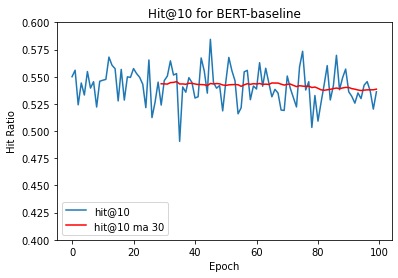

In [27]:
plt.plot(res, label='hit@10')
plt.plot(pd.Series(res).rolling(30).mean(), c='r', label='hit@10 ma 30')
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('Hit@10 for BERT-baseline')
plt.ylim([0.4, 0.6])
plt.legend()

In [ ]:
dqn.c_hist[-1]/sum(dqn.rec_list)

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

In [27]:
torch.save(dqn.model, './torch-ep100.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Baseline. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [35]:
with open('dqn_ep100.pkl', 'wb') as file_pi:
  pickle.dump(dqn, file_pi, pickle.HIGHEST_PROTOCOL)

In [20]:
e = Decay(4, 0.5, 0.1)

In [24]:
type(e) == Decay

True

In [13]:
4*0.7*0.7

1.9599999999999997

In [11]:
2.82842712474619/4.0

0.7071067811865475

In [8]:
for e in range(10): print(4 / ((e + 1) ** (1 / 2)))

4.0
2.82842712474619
2.3094010767585034
2.0
1.7888543819998317
1.6329931618554523
1.5118578920369088
1.414213562373095
1.3333333333333333
1.2649110640673518


In [9]:
4 / ((1) ** (1 / 2))

4.0

## Profiling

In [66]:
%load_ext line_profiler
# %reload_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [67]:
%%time
baseline_model2 = Baseline()

CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 2.13 ms


In [76]:
%%time
exp_replay2 = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon2 = VDBE(0.5, 0.01)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.54 µs


In [81]:
%%time
dqn2 = DQN(baseline_model2, exp_replay2, epsilon2, 5, EPOCH, BATCH_SIZE, LR)

CPU times: user 8.26 s, sys: 144 ms, total: 8.41 s
Wall time: 8.4 s


### Start Chasing

In [82]:
%lprun -f dqn2.train dqn2.train()

Epoch 0 started.   Time: 20:15:21


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 38.1236 s
File: <ipython-input-80-6659d9ecefc0>
Function: train at line 106

Line #      Hits         Time  Per Hit   % Time  Line Contents
   106                                             def train(self):
   107         1     938371.0 938371.0      0.0      self.model.to(DEVICE)
   108         1        664.0    664.0      0.0      self.c_win_cnt = 0
   109         1      40553.0  40553.0      0.0      self.model.train(True)
   110         1       8414.0   8414.0      0.0      self.epsilon.clear()
   111         1        482.0    482.0      0.0      self.explore = 0
   112         1        361.0    361.0      0.0      self.exploit = 0
   113                                           
   114         1        492.0    492.0      0.0      for e in self.epochs:
   115         1        309.0    309.0      0.0        self.rec_cnt = 0
   116         1        224.0    224.0      0.0        self.win_cnt = 0
   117         1        270.0    270.0      0.0      

Epoch: 0/100 | Loss 1.0081119492335264 | Epoch Hit Rate 0.43171806167400884 | Cumulative Hit Rate 0.43171806167400884 | Explore 122 | Exploit 105 | Score 148


In [83]:
%lprun -f dqn2.q_value dqn2.q_value()

Timer unit: 1e-09 s

Total time: 0.000899958 s
File: <ipython-input-80-6659d9ecefc0>
Function: q_value at line 70

Line #      Hits         Time  Per Hit   % Time  Line Contents
    70                                             def q_value(self): 
    71         1        953.0    953.0      0.1      if type(self.epsilon) == Decay: return 0
    72                                             
    73                                               # Get all items
    74                                               # full_input = get_input_v2(self.current_state, self.current_stream).astype('float32')
    75                                               # 紀錄所有預測結果
    76         1     866317.0 866317.0     96.3      predicts = self.model(df_to_tensor(self.full_input).to(DEVICE)).detach().cpu().numpy().flatten()
    77         1        637.0    637.0      0.1      if len(predicts) > 10:
    78         1      18065.0  18065.0      2.0        ind = np.argpartition(predicts, -10)[-10:]
    79  

In [84]:
  # A: [1, 2, 4, 5]
  # B: [1, 2, 3, 4, 5, 6, 7]
  # return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
%lprun -f gen_exist_series gen_exist_series([1, 2, 4, 5], [1, 2, 3, 4, 5, 6, 7])

Timer unit: 1e-09 s

Total time: 3.727e-06 s
File: <ipython-input-52-6ef98bedccbe>
Function: gen_exist_series at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def gen_exist_series(A, B):
    13         1       3727.0   3727.0    100.0    return [int(item in A) for item in B]

### old profiling

In [19]:
%lprun -f exp_replay2.get_batch exp_replay2.get_batch(baseline_model2, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.230175 s
File: <ipython-input-9-4ff322623ba3>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, model, batch_size=10):
    27                                               # How many experiences do we have?
    28         1        816.0    816.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        372.0    372.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35                    

In [21]:
%lprun -f get_input get_input(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.0504328 s
File: <ipython-input-6-c8baae5034eb>
Function: get_input at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def get_input(input_state, current_stream):
    11                                             # Get item feats
    12                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    13         1       2178.0   2178.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    14         1     402689.0 402689.0      0.8    item_feat = BERT_BY_IDX_DF.loc[item_list]
    15                                           
    16                                             # Create new df
    17         1   23229756.0 23229756.0     46.1    stream_item_feat = pd.DataFrame(columns=INPUT_DF_COL)
    18                                           
    19                                             # Fill in other context
    20         1   11686664.0 1168666

### Cleansing
Original Version:
```python
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Convert state format to model input format
'''
def get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]

  # Create new df
  stream_item_feat = pd.DataFrame(columns=INPUT_DF_COL)

  # Fill in other context
  stream_item_feat = stream_item_feat.append([input_state]*len(item_list),ignore_index=True)
  
  # stream_item_feat
  stream_item_feat[LB_ITEMS] = item_feat.reset_index()
  
  return stream_item_feat.astype('float32')
```

In [25]:
%load_ext heat

In [31]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format

LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS
'''
input_state = CONTEXT_REPS.iloc[0]
current_stream = CONTEXT_REPS.iloc[0].name[1]
def new_get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]

  for idx in input_state.index: item_feat[idx] = input_state[idx]
  item_feat_ri = item_feat.reset_index().rename(columns={'index':'item_id'})
  
  return item_feat_ri

In [23]:
%lprun -f new_get_input new_get_input(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.107122 s
File: <ipython-input-22-07c49d6a115a>
Function: new_get_input at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def new_get_input(input_state, current_stream):
    12                                             # Get item feats
    13                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    14         1       2309.0   2309.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    15         1     396509.0 396509.0      0.4    item_feat = BERT_BY_IDX_DF.loc[item_list]
    16                                           
    17       219  105267435.0 480673.2     98.3    for idx in input_state.index: item_feat[idx] = input_state[idx]
    18         1    1455838.0 1455838.0      1.4    item_feat_ri = item_feat.reset_index().rename(columns={'index':'item_id'})
    19                                             
    20         1        133.0    1

In [39]:
def get_input_v2(input_state, current_stream):
  # Get item feats
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  return stream_item_feat

In [85]:
%lprun -f get_input_v2 get_input_v2(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.0176343 s
File: <ipython-input-84-4d017c41242b>
Function: get_input_v2 at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_v2(input_state, current_stream):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       8785.0   8785.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    5560119.0 5560119.0     31.5    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10882756.0 10882756.0     61.7    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                             
    18       

### Chasing 2

In [88]:
%%time
baseline_model3 = Baseline()

CPU times: user 115 µs, sys: 2.91 ms, total: 3.02 ms
Wall time: 2.34 ms


In [89]:
%%time
exp_replay3 = ReplayBuffer(max_memory=MAX_MEMORY)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [90]:
%%time
dqn3 = DQN(baseline_model3, exp_replay3, 5, EPOCH, BATCH_SIZE, LR)

CPU times: user 8.32 s, sys: 177 ms, total: 8.5 s
Wall time: 8.49 s


### Start Chasing

In [91]:
%lprun -f dqn3.train dqn3.train()

Epoch 0 started.   Time: 15:23:38


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 3.32292 s
File: <ipython-input-87-1e430f3ba6d5>
Function: train at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                             def train(self):
    94         1   16194974.0 16194974.0      0.5      self.model.to(DEVICE)
    95         1        950.0    950.0      0.0      self.c_win_cnt = 0
    96         1      40919.0  40919.0      0.0      self.model.train(True)
    97                                           
    98         1        738.0    738.0      0.0      for e in self.epochs:
    99         1        361.0    361.0      0.0        self.rec_cnt = 0
   100         1        335.0    335.0      0.0        self.win_cnt = 0
   101         1        395.0    395.0      0.0        self.loss = 0.
   102         1       1624.0   1624.0      0.0        self.epsilon = 4 / ((e + 1) ** (1 / 2))
   103                                           
   104         1      99669.0  99669.0      0.0    

Epoch: 0/100 | Loss 2.4590116441249847 | Epoch Hit Rate 0.775 | Cumulative Hit Rate 0.775 |              Time 15:23:41


In [92]:
%lprun -f exp_replay3.get_batch exp_replay3.get_batch(baseline_model3, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.0848023 s
File: <ipython-input-86-f9f91d8b7747>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, model, batch_size=10):
    27                                               # How many experiences do we have?
    28         1       1013.0   1013.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        741.0    741.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35                  

Per hit
* exp/get_input:
  * v1: `49609136.0`
  * v2: `12412833.5`
* train/get_batch:
  * v1: `216278453.8`
  * v2: `78445226.8`